In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [2]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")

In [3]:
from data.get_data import get_gauss_pairs_dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import gpflow


x, y, _, _ = get_gauss_pairs_dataset("/vol/bitbucket/ad6013/Research/gp-causal/data/gauss_pairs/files")
# Get data
# X = np.random.randn(2000, 1)
# Y = (X) + X  * (np.random.randn(2000, 1))
X = y[180]
Y = x[180]
N = X.shape[0]
num_minibatch = 500

X = StandardScaler().fit_transform(X).astype(np.float64)
Y = StandardScaler().fit_transform(Y).astype(np.float64)

In [4]:
X.shape[0]

1500

In [5]:
from models.GeneralisedGPLVM import GeneralisedGPLVM
from gpflow.config import default_float

In [6]:
from tqdm import trange
from gpflow.optimizers import NaturalGradient
import gpflow
import matplotlib.pyplot as plt


# tf.config.run_functions_eagerly(
#     True
# )

def run_optimizer(model, train_dataset, iterations, minibatch_size):
    """
    Utility function running the Adam optimizer
    Modified from https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    # gpflow.set_trainable(model.q_mu, False)
    # gpflow.set_trainable(model.q_sqrt, False)
    # variational_params = [(model.q_mu, model.q_sqrt)]
    # natgrad_opt = NaturalGradient(gamma=0.5)
    optimizer = tf.optimizers.Adam(0.005)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        # natgrad_opt.minimize(training_loss, variational_params)
    iterator = trange(iterations, leave=True) 
    for step in iterator:
        optimization_step()
        neg_elbo = training_loss().numpy()
        logf.append(neg_elbo)
        if step % 1000 == 0:
            iterator.set_description(f"EPOCH: {step}, NEG ELBO: {neg_elbo}")

            plt.plot(np.arange(len(logf)), logf)
            plt.show()
            plt.close()

            obs_new = np.linspace(-5, 5, 3000)[:, None]

            lower, median, upper, samples = model.predict_credible_layer(
                Xnew=obs_new,
                obs_noise=True,
            )
            plt.scatter(X[:, 0], Y[:, 0], c='r')
            plt.plot(obs_new, median, c='b', alpha=0.2)
            # plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
            plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
            plt.show()
            plt.close()

            obs_new = np.linspace(-5, 5, 1000)[:, None]
            latent_new = np.random.randn(1000, 1)
            full_new =  np.concatenate([obs_new, latent_new], axis=1)
            pred_y_mean, pred_y_var = model.predict_y(
                full_new, full_cov=False, full_output_cov=False 
            )
            plt.scatter(X[:, 0], Y[:, 0], c='r')
            plt.plot(obs_new, pred_y_mean, c='b', alpha=0.2)
            # plt.scatter(inducing_in, np.zeros(100) )
            plt.fill_between(obs_new[:, 0], (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0], (pred_y_mean - 2 * np.sqrt(pred_y_var))[:,0], alpha=0.5)
            plt.show()
            plt.close()


            # if np.abs(np.mean(logf[-5000:])) - np.abs(np.mean(logf[-100:])) < 0.25 * np.std(logf[-100:]):
            #     print("\n BREAKING! \n")
            #     break
            
    return logf

In [7]:
M = 200  # Number of inducing locations

kernel_1 = gpflow.kernels.SquaredExponential(
    lengthscales=[0.1, 0.011]
)
kernel_1.variance.assign(1.0)
kernel_2 = gpflow.kernels.Linear(variance=1.0)
kernel = gpflow.kernels.Sum([kernel_1, kernel_2])
Z = np.concatenate(
        [
            np.linspace(X.min(), X.max(), M).reshape(-1, 1),
            np.random.randn(M, 1),
        ],
        axis=1
    )
X_mean_init = 0.01 * tf.cast(Y, default_float())
X_var_init = tf.cast(
    np.random.uniform(0, 0.1, (X.shape[0], 1)), default_float()
)


model = GeneralisedGPLVM(
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    kernel=kernel,
    likelihood=gpflow.likelihoods.Gaussian(variance=1e-5),
    num_mc_samples=10,
    inducing_variable=Z,
    batch_size=num_minibatch,
)

2022-09-16 16:10:25.034879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 16:10:25.191119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 16:10:25.191385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 16:10:25.192380: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

  0%|          | 0/100000 [00:00<?, ?it/s]2022-09-16 16:10:26.354129: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-09-16 16:10:31.153046: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8156830
EPOCH: 0, NEG ELBO: 220552676.72829872:   0%|          | 0/100000 [00:07<?, ?it/s]

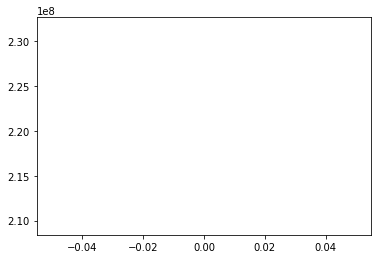

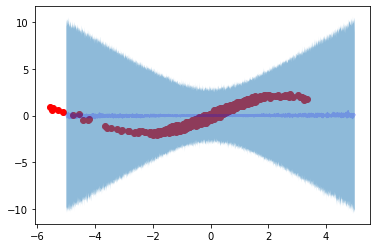

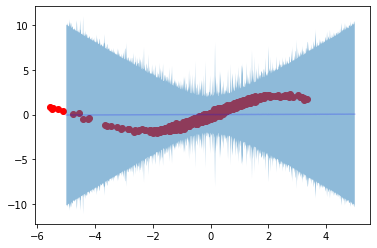

EPOCH: 1000, NEG ELBO: 348490.7271065239:   1%|          | 998/100000 [00:24<23:49, 69.27it/s]

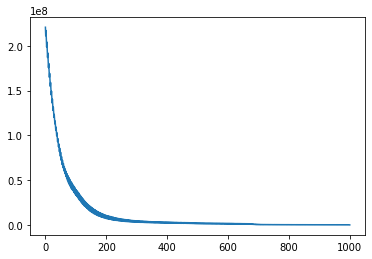

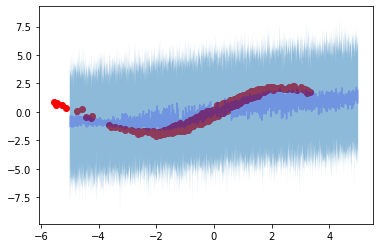

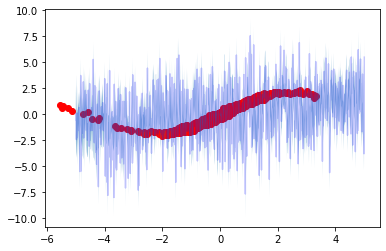

EPOCH: 2000, NEG ELBO: 181370.4753697205:   2%|▏         | 1996/100000 [00:40<23:37, 69.16it/s]  

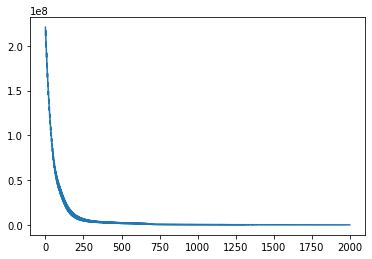

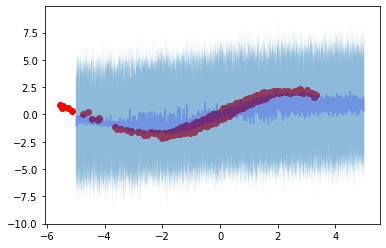

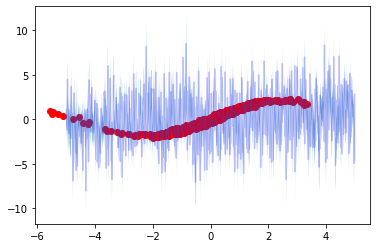

EPOCH: 3000, NEG ELBO: 64456.31097491844:   3%|▎         | 2994/100000 [00:57<23:22, 69.16it/s]  

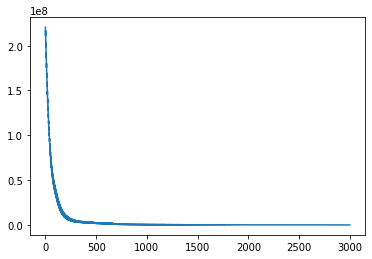

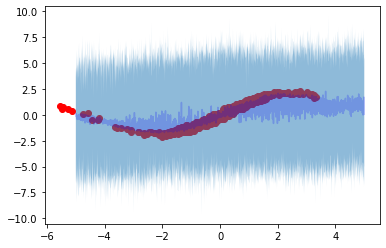

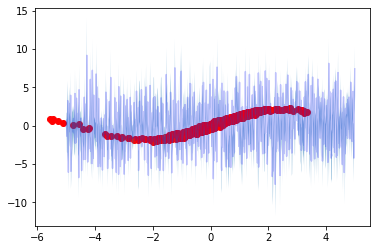

EPOCH: 4000, NEG ELBO: 26911.526685642213:   4%|▍         | 3996/100000 [01:13<23:10, 69.05it/s] 

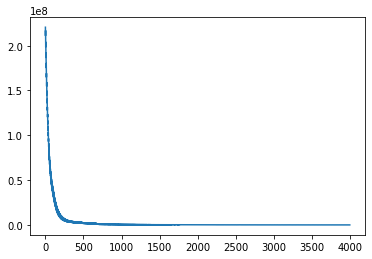

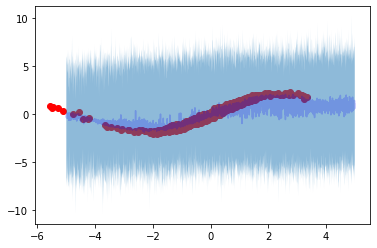

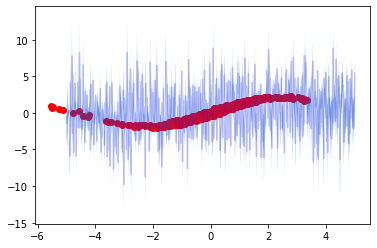

EPOCH: 5000, NEG ELBO: 22829.420101497424:   5%|▍         | 4993/100000 [01:29<22:47, 69.49it/s]  

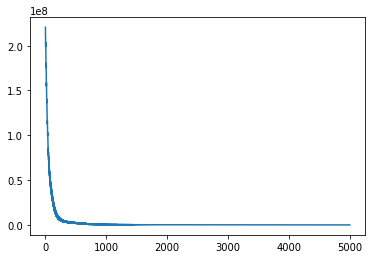

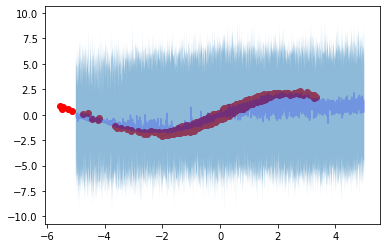

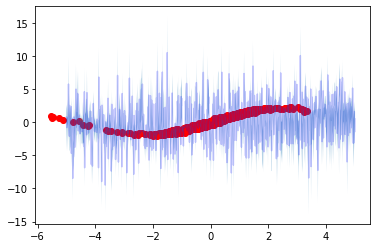

EPOCH: 6000, NEG ELBO: 12217.002875236874:   6%|▌         | 6000/100000 [01:46<22:31, 69.55it/s]  

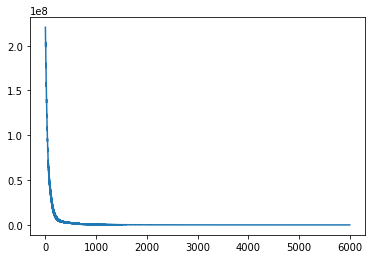

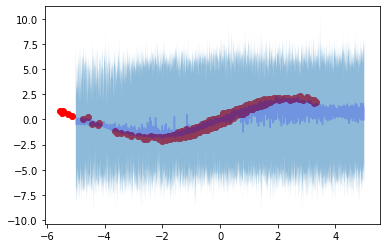

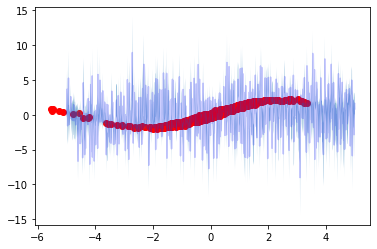

EPOCH: 7000, NEG ELBO: 4657.669158716789:   7%|▋         | 6999/100000 [02:02<22:35, 68.59it/s]   

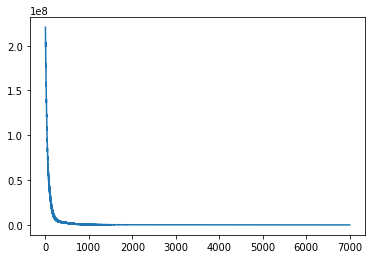

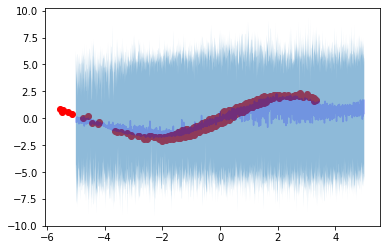

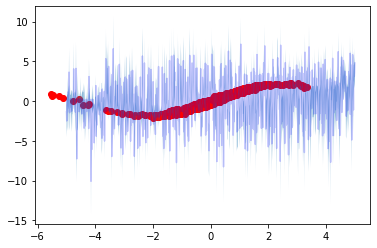

EPOCH: 8000, NEG ELBO: 8115.740618149559:   8%|▊         | 7995/100000 [02:18<22:02, 69.55it/s]  

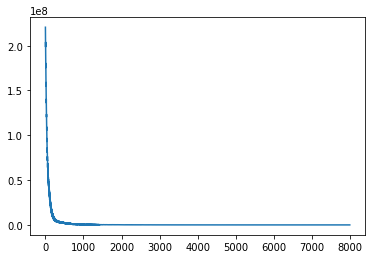

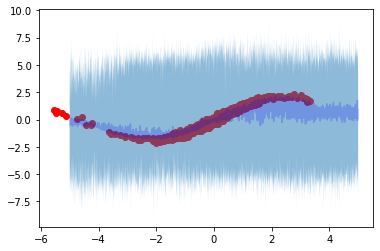

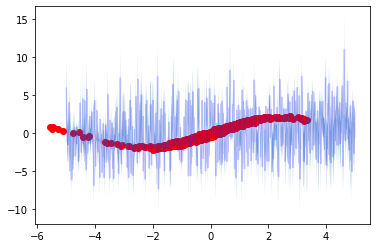

EPOCH: 9000, NEG ELBO: 2294.7679598343366:   9%|▉         | 9000/100000 [02:35<21:51, 69.38it/s] 

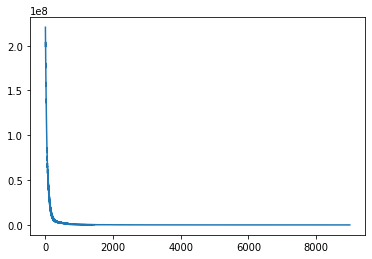

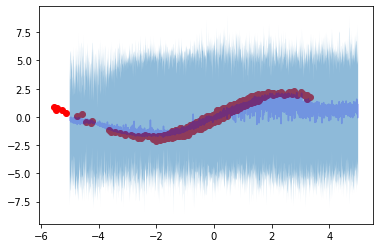

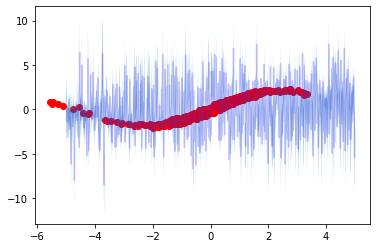

EPOCH: 10000, NEG ELBO: 480.8834628643076:  10%|▉         | 9994/100000 [02:51<21:30, 69.76it/s]  

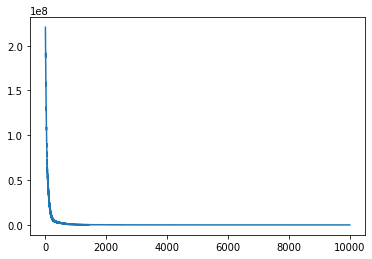

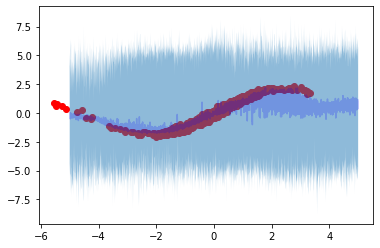

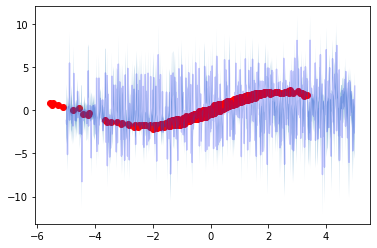

EPOCH: 11000, NEG ELBO: 615.1028459651985:  11%|█         | 11000/100000 [03:07<21:34, 68.75it/s]  

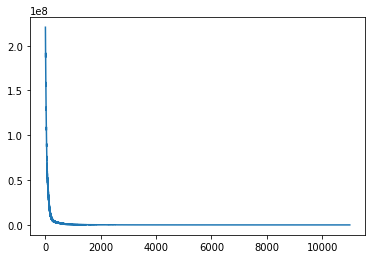

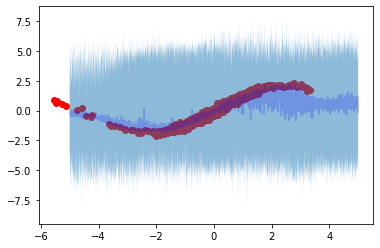

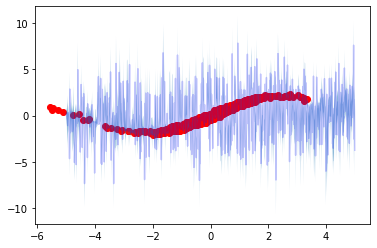

EPOCH: 12000, NEG ELBO: 178.90145883998662:  12%|█▏        | 11998/100000 [03:24<21:05, 69.51it/s] 

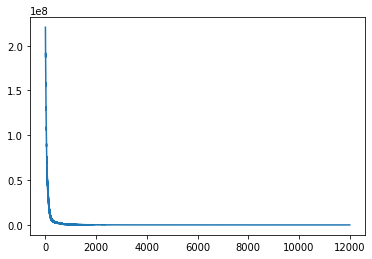

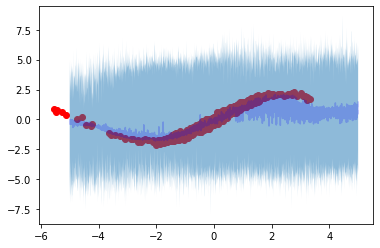

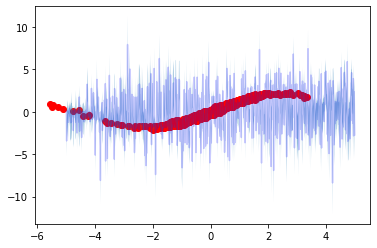

EPOCH: 13000, NEG ELBO: 639.8106564854784:  13%|█▎        | 12997/100000 [03:40<20:46, 69.78it/s]   

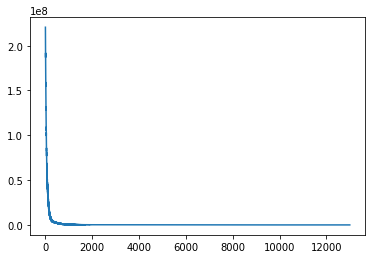

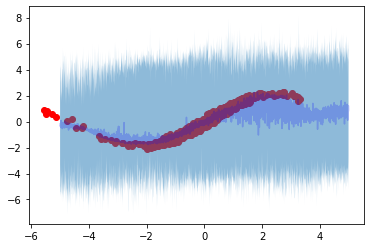

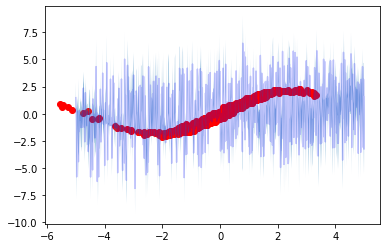

EPOCH: 14000, NEG ELBO: -614.1093053732596:  14%|█▍        | 13996/100000 [03:57<20:25, 70.19it/s] 

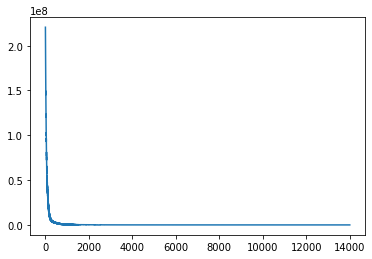

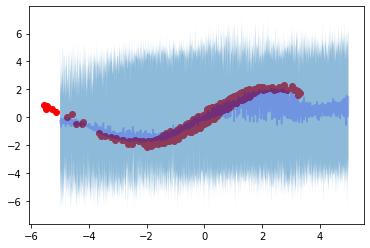

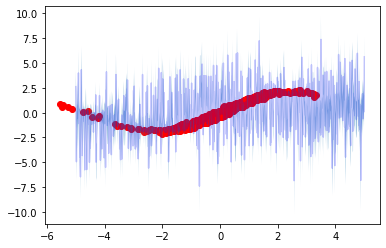

EPOCH: 15000, NEG ELBO: -445.066888281729:  15%|█▌        | 15000/100000 [04:13<20:19, 69.71it/s]   

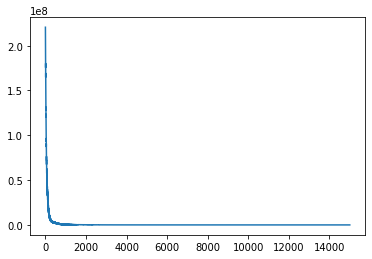

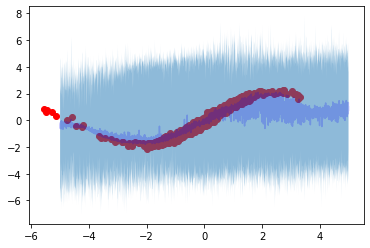

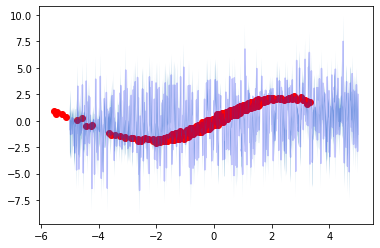

EPOCH: 16000, NEG ELBO: -581.4709877372195:  16%|█▌        | 15997/100000 [04:29<20:09, 69.43it/s] 

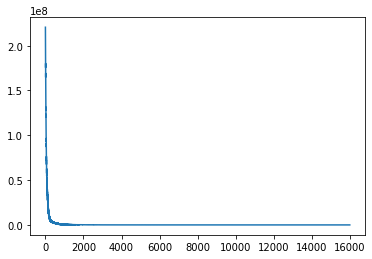

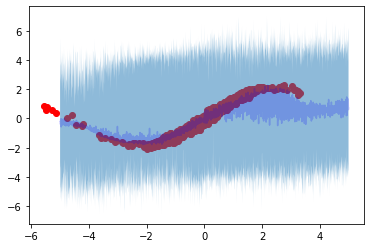

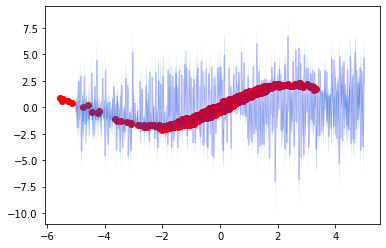

EPOCH: 17000, NEG ELBO: -1076.932513087485:  17%|█▋        | 16997/100000 [04:46<19:56, 69.39it/s]  

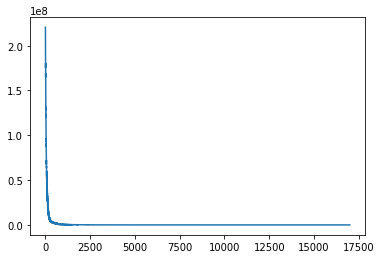

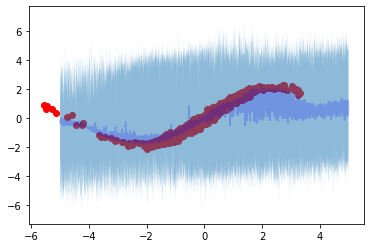

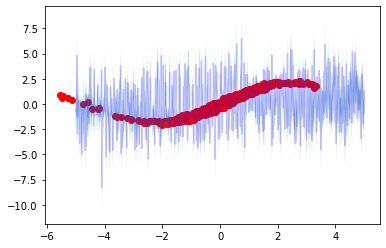

EPOCH: 18000, NEG ELBO: -918.9649677075073:  18%|█▊        | 17997/100000 [05:02<19:39, 69.51it/s]  

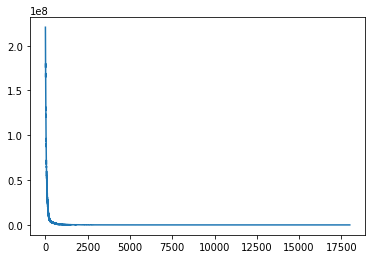

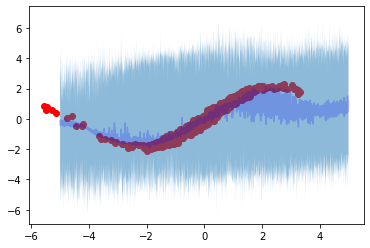

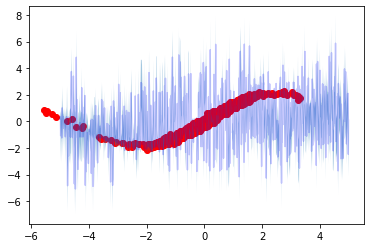

EPOCH: 19000, NEG ELBO: -906.7890721378669:  19%|█▉        | 18996/100000 [05:19<19:20, 69.82it/s]  

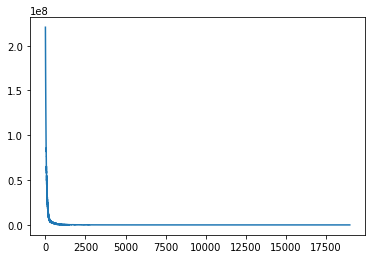

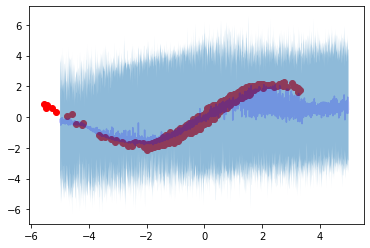

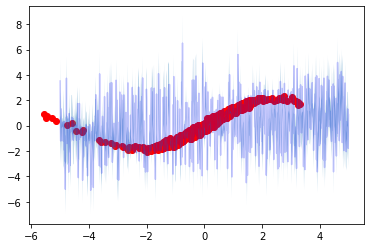

EPOCH: 20000, NEG ELBO: -970.7162609668907:  20%|█▉        | 19997/100000 [05:35<19:11, 69.48it/s]  

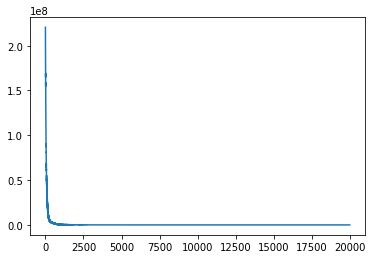

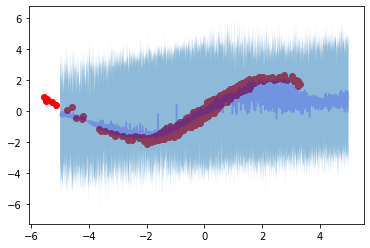

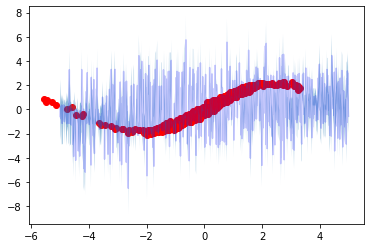

EPOCH: 21000, NEG ELBO: -1082.4264360738239:  21%|██        | 20994/100000 [05:51<19:04, 69.06it/s] 

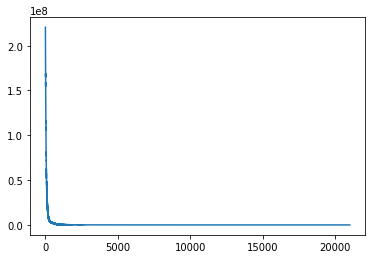

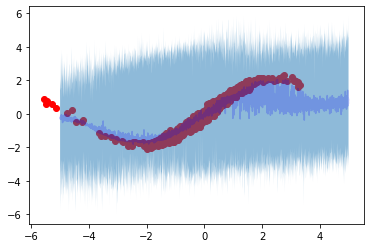

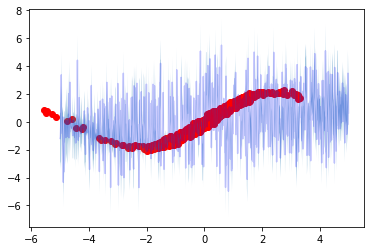

EPOCH: 22000, NEG ELBO: -1128.7287798892635:  22%|██▏       | 22000/100000 [06:08<18:40, 69.62it/s]  

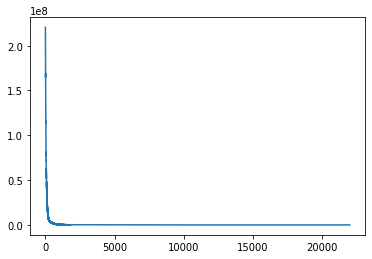

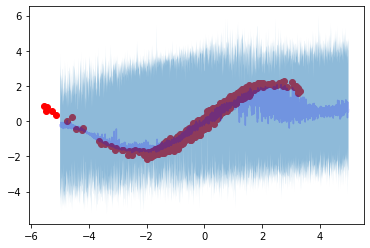

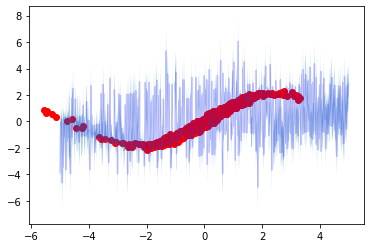

EPOCH: 23000, NEG ELBO: -990.6899633083026:  23%|██▎       | 22996/100000 [06:24<18:35, 69.04it/s]   

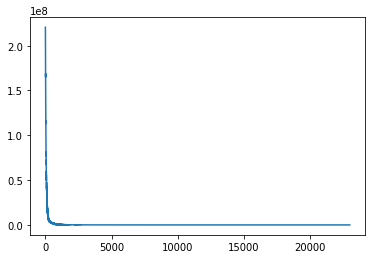

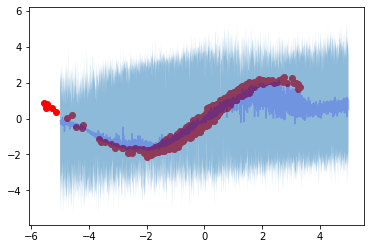

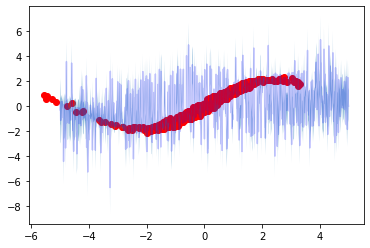

EPOCH: 24000, NEG ELBO: -994.9382572955363:  24%|██▍       | 24000/100000 [06:41<18:06, 69.97it/s]  

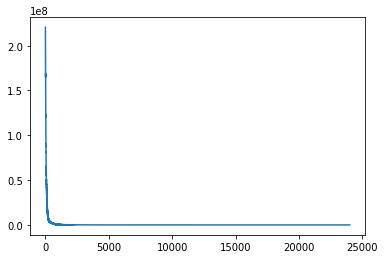

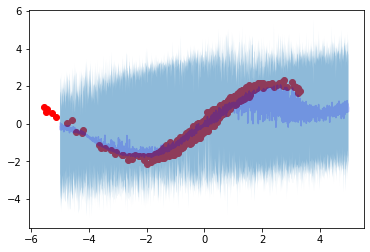

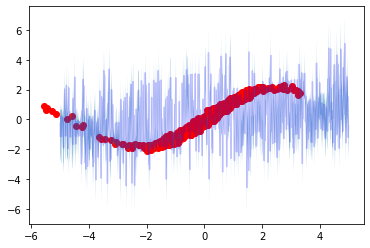

EPOCH: 25000, NEG ELBO: -1224.967166105899:  25%|██▍       | 24996/100000 [06:57<18:03, 69.20it/s]  

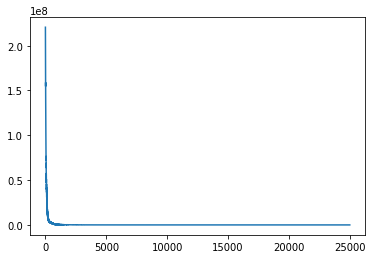

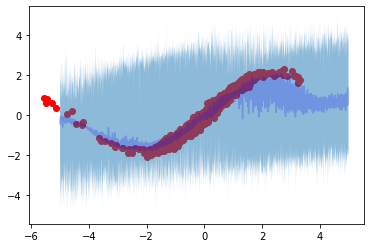

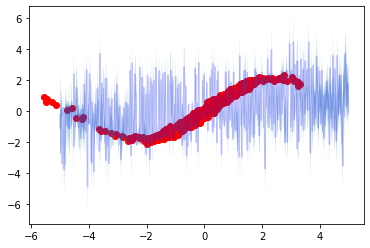

EPOCH: 26000, NEG ELBO: -1046.1538733134344:  26%|██▌       | 25997/100000 [07:13<17:39, 69.81it/s] 

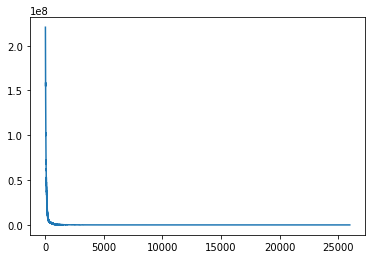

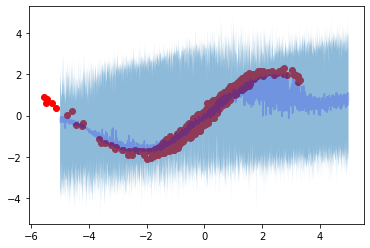

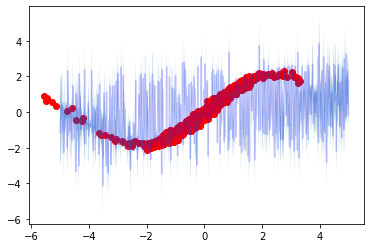

EPOCH: 27000, NEG ELBO: -1227.723609566694:  27%|██▋       | 26995/100000 [07:30<17:29, 69.54it/s]   

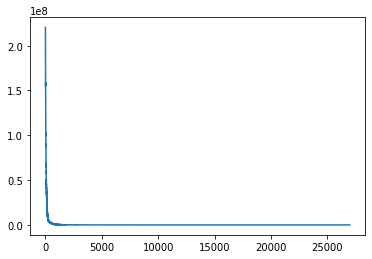

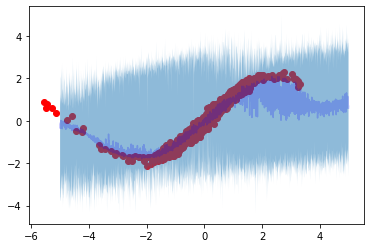

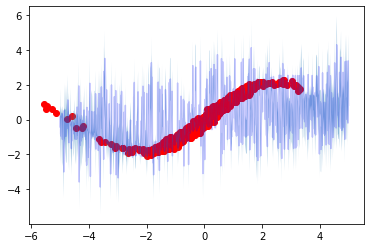

EPOCH: 27000, NEG ELBO: -1227.723609566694:  27%|██▋       | 27065/100000 [07:33<21:46, 55.83it/s]  

In [8]:
data_idx = np.arange(X.shape[0])
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y, data_idx)).repeat()
logf = run_optimizer(
    model=model,
    train_dataset=train_dataset,
    iterations=100000,
    minibatch_size=num_minibatch
)

In [ ]:
logf[-1000:]

[-3803.478322329391,
 -3798.0621664157243,
 -3799.9730844099845,
 -3805.643232554408,
 -3790.397340708662,
 -3783.8289785395086,
 -3783.7295798965997,
 -3775.628239331905,
 -3803.9412920283658,
 -3783.1377534983026,
 -3785.8789695900277,
 -3778.419377957899,
 -3782.696053617256,
 -3810.0221176099153,
 -3787.559205754753,
 -3777.9400904808926,
 -3792.6481292904127,
 -3786.4808404258542,
 -3775.0852297228153,
 -3775.5903260698324,
 -3783.3256340134276,
 -3777.917021985242,
 -3776.011832316426,
 -3784.0067988895516,
 -3776.824764394866,
 -3772.937185933302,
 -3774.5609504570652,
 -3779.9436158179324,
 -3742.4166802686314,
 -3763.779134792061,
 -3736.9198552786656,
 -3745.8216969377327,
 -3737.519890822875,
 -3719.2668724850178,
 -3741.9596966210643,
 -3751.8448166686258,
 -3721.081139225562,
 -3739.3530645060746,
 -3699.0658555796776,
 -3697.162651995749,
 -3725.201661954103,
 -3670.62336950775,
 -3696.0434880151015,
 -3698.357595080582,
 -3707.133857631869,
 -3719.891912457687,
 -3728.34

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y, data_idx)).repeat().shuffle(N)


In [ ]:
print(f"Loss is {- model.elbo((X, Y, np.arange(len(X))[::-1] ))}")

Loss is 286718.61451927724


In [ ]:
model.num_mc_samples = 10
print(f"Loss is {- model.elbo((X, Y, data_idx))}")

Loss is -3783.360038405073


In [ ]:
data_idx

array([   0,    1,    2, ..., 1497, 1498, 1499])

In [ ]:
X

array([[-1.3486502 ],
       [-0.76732086],
       [-0.48816444],
       ...,
       [-0.14626154],
       [-1.35775469],
       [ 0.31038113]])

In [ ]:
import matplotlib.pyplot as plt

obs_new = np.linspace(-5, 5, 1000)[:, None]
latent_new = np.random.randn(1000, 1)
full_new =  np.concatenate([obs_new, latent_new], axis=1)

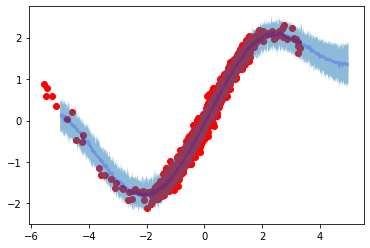

In [ ]:
lower, median, upper, samples = model.predict_credible_layer(obs_new, obs_noise=True)

plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, median, c='b', alpha=0.2)
# plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
plt.show()
plt.close()

In [ ]:
data_idx = np.arange(X.shape[0])
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y, data_idx)).repeat()
ds_iter = iter(train_dataset.batch(1500))

In [ ]:

print(next(ds_iter))

(<tf.Tensor: shape=(1500, 1), dtype=float64, numpy=
array([[-1.3486502 ],
       [-0.76732086],
       [-0.48816444],
       ...,
       [-0.14626154],
       [-1.35775469],
       [ 0.31038113]])>, <tf.Tensor: shape=(1500, 1), dtype=float64, numpy=
array([[-1.7094654 ],
       [-0.80610062],
       [-0.80919514],
       ...,
       [-0.12434738],
       [-1.5289538 ],
       [ 0.48074444]])>, <tf.Tensor: shape=(1500,), dtype=int64, numpy=array([   0,    1,    2, ..., 1497, 1498, 1499])>)


In [ ]:
print(next(ds_iter))

(<tf.Tensor: shape=(1500, 1), dtype=float64, numpy=
array([[-1.3486502 ],
       [-0.76732086],
       [-0.48816444],
       ...,
       [-0.14626154],
       [-1.35775469],
       [ 0.31038113]])>, <tf.Tensor: shape=(1500, 1), dtype=float64, numpy=
array([[-1.7094654 ],
       [-0.80610062],
       [-0.80919514],
       ...,
       [-0.12434738],
       [-1.5289538 ],
       [ 0.48074444]])>, <tf.Tensor: shape=(1500,), dtype=int64, numpy=array([   0,    1,    2, ..., 1497, 1498, 1499])>)


In [ ]:
data_idx = tf.range(10) + 10
data = tf.range(20)[:, None] + 100

In [ ]:
data_idx

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>

In [ ]:
data

<tf.Tensor: shape=(20, 1), dtype=int32, numpy=
array([[100],
       [101],
       [102],
       [103],
       [104],
       [105],
       [106],
       [107],
       [108],
       [109],
       [110],
       [111],
       [112],
       [113],
       [114],
       [115],
       [116],
       [117],
       [118],
       [119]], dtype=int32)>

In [ ]:
tf.gather(data, [0 ,10, 1])

<tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[100],
       [110],
       [101]], dtype=int32)>